You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it's infeasible to label them by hand. Luckily, you have a small training set of about 10,000 recipes with labeled cuisines.

- Design and execute a method to predict the cuisine of a recipe given only its ingredients. 
    - Data Due Diligence: All-Purpose Flour and Flour are likely the same ingredient, but red onions and yellow onions are incredibly different.
- For each major cuisine, what are the driving ingredients that characterize it? What are the features of a cuisine that drive misclassification in your method above?
- How could you design this to be robust enough to understand similarities / substitutions between ingredients? 
- Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2


import lightgbm as lgb
import xgboost as xgb

import random

import seaborn as sns

import time

In [2]:
with open('recipies.json') as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data=data)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [7]:
# ### See this for how to do this
# #https://datascience.stackexchange.com/questions/11797/split-a-list-of-values-into-columns-of-a-dataframe

# df['ingredients'] = df['ingredients'].apply(frozenset)
# for ingredient in frozenset.union(*df.ingredients):
#     df[ingredient] = df.apply(lambda _: int(ingredient in _.ingredients), axis=1)
#df_results.shape

In [8]:
df['ingredients_str'] = df['ingredients'].apply(','.join) # this converts ingredients columns into arrays


In [9]:
df['ingredients_str'] = df['ingredients_str'].map(lambda x: x.lower())

In [10]:
mlb = MultiLabelBinarizer()
result = mlb.fit_transform(df['ingredients_str'].apply(lambda x: [y.strip() for y in x.split(',')]))
df_results = pd.DataFrame(data=result, columns=mlb.classes_)


# EDA - most important ingredients per cuisine

In [11]:
list_of_cuisines = list(df['cuisine'].unique())

In [12]:


df_combined = df_results.join(df[['cuisine']])
df_combined.head()

,,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1 inch thick,1% low-fat buttermilk,1% low-fat chocolate milk,...,za'atar,zatarains creole seasoning,zatarain’s jambalaya mix,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,greek
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,filipino
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian


In [13]:
# Count the max. number of ingredients used per cuisine
n = 20
dict_ingredients = {}
for cuisine in list_of_cuisines:
    df_mini = df_combined[df_combined['cuisine'] == cuisine].drop('cuisine', axis=1)
    column_sum = df_mini.sum(axis=0)
    df_column_count = pd.DataFrame(column_sum)
    df_column_count[0] = df_column_count[0].astype(int)
    df_column_count= df_column_count.sort_values(by=0, ascending=False)  
    
    dict_ingredients[cuisine] = list(df_column_count[0:n].index)

# Check out how often they're counted    
ingredient_count = {}
for key in dict_ingredients.keys():
    for ingredient in dict_ingredients[key]:
        ingredient_count[ingredient] = ingredient_count.get(ingredient, 0) + 1
        
# Now go back and calculate what ingredients stand out for each
cutoff = 15;
importance_count = {}
for key in dict_ingredients.keys():
    stuff = []
    for ingredient in dict_ingredients[key]:
        temp = n-ingredient_count[ingredient]
        if temp >= cutoff:
            stuff.append(ingredient)

    importance_count[key] = stuff
        
        

['salt', 'olive oil', 'dried oregano', 'garlic cloves', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'ground black pepper', 'garlic', 'pepper', 'feta cheese', 'cucumber', 'purple onion', 'onions', 'lemon juice', 'tomatoes', 'water', 'lemon', 'fresh parsley', 'fresh dill']
['salt', 'olive oil', 'dried oregano', 'garlic cloves', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'ground black pepper', 'garlic', 'pepper', 'feta cheese', 'cucumber', 'purple onion', 'onions', 'lemon juice', 'tomatoes', 'water', 'lemon', 'fresh parsley', 'fresh dill']
['salt', 'olive oil', 'dried oregano', 'garlic cloves', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'ground black pepper', 'garlic', 'pepper', 'feta cheese', 'cucumber', 'purple onion', 'onions', 'lemon juice', 'tomatoes', 'water', 'lemon', 'fresh parsley', 'fresh dill']
['salt', 'olive oil', 'dried oregano', 'garlic cloves', 'feta cheese crumbles', 'extra-virgin olive oil

In [15]:
for key in importance_count.keys():
    print(key+': ', ', '.join(importance_count[key]))
    
    print('')

greek:  dried oregano, feta cheese crumbles, extra-virgin olive oil, fresh lemon juice, feta cheese, cucumber, purple onion, lemon juice, tomatoes, lemon, fresh parsley, fresh dill

southern_us:  baking powder, unsalted butter, milk, buttermilk, vanilla extract, baking soda, kosher salt

filipino:  oil, fish sauce, bay leaves, cooking oil, brown sugar, coconut milk, ginger

indian:  garam masala, ground turmeric, cumin seed, ground cumin, oil, ginger, tomatoes, tumeric, chili powder, green chilies, curry powder, ground coriander, fresh ginger

jamaican:  ground allspice, scallions, dried thyme, black pepper, ground cinnamon, brown sugar, thyme, coconut milk, curry powder

spanish:  extra-virgin olive oil, tomatoes, red bell pepper, kosher salt, fresh parsley, dry white wine, saffron threads, paprika, flat leaf parsley

italian:  grated parmesan cheese, extra-virgin olive oil, fresh basil, dry white wine, kosher salt, black pepper, fresh parsley, dried oregano

mexican:  ground cumin, c

# Let's see if we can get the ~6700 features into a nicer shape for applying Machine Learning

In [16]:
df_results.head()

,,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1 inch thick,1% low-fat buttermilk,1% low-fat chocolate milk,...,yuzukosho,za'atar,zatarains creole seasoning,zatarain’s jambalaya mix,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
column_sum = df_results.sum(axis=0)
df_column_count = pd.DataFrame(column_sum)#.T
df_column_count[0] = df_column_count[0].astype(int)
df_column_count= df_column_count.sort_values(by=0, ascending=False)

Text(0.5, 1.0, 'Histogram of values')

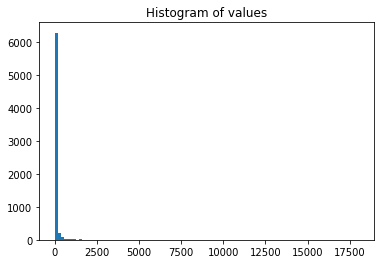

In [18]:

plt.hist(df_column_count[0].values, bins=100)

plt.title('Histogram of values')

In [19]:
# Option 1: Just keep the columns with the most "stuff"
cutoff = 100
keep_list = df_column_count[df_column_count[0]>=cutoff].T.columns
naughty_list = df_column_count[df_column_count[0]<cutoff].T.columns


len(keep_list), len(naughty_list)

(650, 6062)

In [20]:
# Option 2: 
k = 650



In [21]:
# Look at 10 random items in the naughty list
for i in range(10):
    print(random.choice(naughty_list))

pound cake mix
capon
peasant bread
reduced sugar orange marmalade
rotel tomatoes
snapper fillets
manchego cheese
wheatberries
unsalted pumpkinseed kernels
striped bass


In [22]:
#sns.heatmap(df_results[keep_list].join(df[['cuisine']]).corr())

In [23]:
#print(list(keep_list))

In [31]:
class_names = list(df_results.columns)

In [32]:
# How many words are in each class
class_count = [len(x.split()) for x in class_names]
df_names = pd.DataFrame(data=[class_names, class_count])
df_names = df_names.T
df_names.head()


,0,1
0,,0
1,( oz.) tomato sauce,4
2,( oz.) tomato paste,4
3,(10 oz.) frozen chopped spinach,5
4,(14 oz.) sweetened condensed milk,5


In [34]:
df_names =df_names.sort_values(by=1, ascending=False)

In [35]:
df_names

,0,1
3067,i can't believ it' not butter! made with olive...,11
3365,kraft mexican style shredded four cheese with ...,11
3375,kraft shredded pepper jack cheese with a touch...,10
3065,hurst family harvest chipotle lime black bean ...,9
450,bertolli vineyard premium collect marinara wit...,9
1479,condensed reduced fat reduced sodium cream of ...,9
1478,condensed reduced fat reduced sodium cream of ...,9
2969,hidden valley® original ranch salad® dressing ...,9
4844,ragu old world style sweet tomato basil pasta ...,9
3068,i can't believe it's not butter!® all purpose ...,9


In [ ]:
df_names['length'] = df_names[0].apply(len)

In [ ]:
list(df_names.sort_values(by='length')[0])

In [ ]:
# stuff_to_drop = [mi',
#  'v8',
#  'msg',
#  'val',
#  'mie',
#  'dal',
#  'tvp',
#  'poi',
#  'any',
#  'rye',
#  'kha',
#  'rub',
#  'uni',
#  'red',
#  'min',]

# def CleanTokens(x):
#     for i in x:
        
        
# df['ingredients'].map(CleanTokens)

In [ ]:
[x for x in class_names if '(' in x]

In [ ]:
#df_result = pd.DataFrame(result, columns=mlb.classes_,index=df.index).columns


In [ ]:
# #
# mlb = MultiLabelBinarizer()
# df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('ingredients')),
#                           columns=mlb.classes_,
#                           index=df.index))
#df_result

# TF-IDF



In [ ]:
# tf = TfidfVectorizer(analyzer='word', 
#                      min_df=10,
#                      ngram_range=(1, 2),
#                      stop_words='english')


# LDA

# MVP model - XGBoost

In [ ]:
mlb = MultiLabelBinarizer()
X = pd.DataFrame(data=mlb.fit_transform(df['ingredients_str'].apply(lambda x: [y.strip() for y in x.split(',')])), 
                                    columns=mlb.classes_)

In [ ]:
X = df_results[keep_list]

In [ ]:
y = df['cuisine']

In [ ]:
label_encoder = LabelEncoder()

label_encoder = label_encoder.fit(y)
y_numeric = label_encoder.transform(y)

In [ ]:
y

In [ ]:
label_encoder.inverse_transform(y_numeric)

In [ ]:
# list(label_encoder.inverse_transform(y_numeric)) == list(y)

In [ ]:
label_encoder.classes_

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y_numeric, test_size = 0.2)

In [ ]:
d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test)#, label=y_test)

In [ ]:
params = {'max_depth': 6, 
          'objective': 'multi:softmax',
          'num_class' :20,
          'eta': 0.5,
          'booster': 'gbtree',
          'eval_metric': 'merror',
          'feature_names': label_encoder.classes_}

In [ ]:
t = time.time()

xgb_model = xgb.train(params, d_train)

print('Elapsed Time: ', time.time()-t)

In [ ]:
y_pred_xgb = xgb_model.predict(d_test)
y_pred_xgb = y_pred_xgb.astype(int)

y_pred_xgb

In [ ]:
print(y_pred_xgb)

In [ ]:
label_encoder.inverse_transform(y_pred_xgb)

In [ ]:
# jury rigged accuracy score for multiclass classification

test = y_test == y_pred_xgb
sum(test)/len(test)

In [ ]:
feature_scores = xgb_model.get_score()

In [ ]:
df_scores = pd.DataFrame.from_dict(feature_scores, orient='index')

In [ ]:
df_scores = df_scores.sort_values(0, ascending=False)

In [ ]:
df_scores

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(df_scores[0:20].T.columns, df_scores[0:20].T.values[0])

plt.xticks(rotation=90)

plt.title('Feature Importances')
# plt.bar(range(len(feature_scores)), list(feature_scores.values()), align='center')
# plt.xticks(range(len(feature_scores)), list(feature_scores.keys()))
# # # for python 2.x:
plt.tight_layout()

plt.savefig('xgb_feature_importances.png')

# Try results from K_best

In [ ]:
t = time.time()

X_train, X_test, y_train, y_test= train_test_split(x_chisq, y_numeric, test_size = 0.2)

d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test)


xgb_model = xgb.train(params, d_train)

y_pred_xgb = xgb_model.predict(d_test)
y_pred_xgb = y_pred_xgb.astype(int)

y_pred_xgb

print('Elapsed Time: ', time.time()-t)

In [ ]:
(y_pred_xgb

label_encoder.inverse_transform([6]))

In [ ]:
index = (y_test == 6)
index

In [ ]:
names = []
accuracies = []
for i in range(20):
    cuisine_name = label_encoder.inverse_transform([i])[0]
    
    index = (y_test == i)
    
    
    test = y_test[index] == y_pred_xgb[index]
    accuracy = sum(test)/len(test)
    
    print(cuisine_name, accuracy)
    names.append(cuisine_name)
    accuracies.append(accuracy)

In [ ]:
names
accuracies
df_accuracy = pd.DataFrame([names, accuracies]).T

In [ ]:
df_accuracy = df_accuracy.sort_values(by=1, ascending=False)

In [ ]:
plt.bar(df_accuracy[0], df_accuracy[1])
plt.xticks(rotation=90)

plt.title('Accuracy of individual classes')

In [ ]:
df['cuisine'].value_counts()

In [ ]:
accuracies.sort()

In [ ]:
#import imbalanced-learn

from  imblearn.over_sampling import SMOTE

In [ ]:
# jury rigged accuracy score for multiclass classification

test = y_test == y_pred_xgb
sum(test)/len(test)